# MNIST e-prop training notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# from torchvision.datasets import MNIST
# from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import snntorch as snn 
from snntorch import spikegen
# from snntorch.spikevision import spikedata
import snntorch.spikeplot as splt

import tonic
from tonic import transforms

## Load Datasets and DataLoaders

### Load Neuromorphic-MNIST Datasets

In [2]:
datapath = "../data"
train_dataset = tonic.datasets.NMNIST(datapath, train=True)
test_dataset = tonic.datasets.NMNIST(datapath, train=False)

In [3]:
events, target = train_dataset[60000-1]
events, events.shape, target, train_dataset.__len__()

(array([(18, 30,     55, 1), ( 7, 24,    501, 0), (18,  9,    807, 0), ...,
        ( 8, 20, 302958, 0), (23,  8, 304007, 1), (18, 15, 304231, 1)],
       dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]),
 (3551,),
 8,
 60000)

In [4]:
# Convert stream of (x,y,t,p) events into stack of 3 image frames
N_TIME_BINS = 3
FIG_SIZE = (4, 3)
sensor_size = train_dataset.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=N_TIME_BINS)  # 3 saccades

frames = frame_transform(events)
frames.shape

(3, 2, 34, 34)

### Stack events into frames

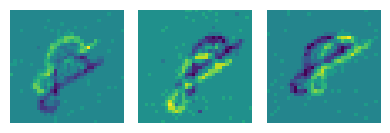

In [5]:
def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=FIG_SIZE)
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1] - frame[0])
        axis.axis("off")
    plt.tight_layout()


plot_frames(frames)

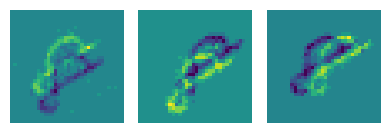

In [6]:
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

events_denoised = denoise_transform(events)
frames_denoised = frame_transform(events_denoised)

plot_frames(frames_denoised)

### Create DataLoaders

We stick with FrameTransform representation for now.

In [7]:
FILTER_TIME = 10000  # Max ms between events otherwise get filtered
N_TIME_BINS = 3  # No. saccades

denoise_transform = transforms.Denoise(filter_time=FILTER_TIME)
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=N_TIME_BINS)
type_transform = transforms.NumpyAsType(dtype = np.float32)  # Events must match weight dtype (torch.float32)

transform = transforms.Compose([denoise_transform, frame_transform, type_transform])
train_dataset = tonic.datasets.NMNIST("../data", train=True, transform=transform)
test_dataset = tonic.datasets.NMNIST("../data", train=False, transform=transform)

In [8]:
# Load Dataloaders
BATCH_SIZE = 1  # Online training

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

torch.Size([1, 3, 2, 34, 34]) 1


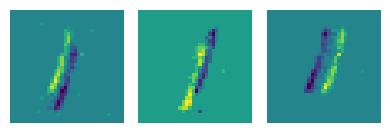

In [9]:
frames, target = next(iter(train_dataloader))
print(frames.shape, target[0].item())
plot_frames(frames[0].squeeze())

## Define Network

For now, feed each frame one by one to network, flattening the polarities (ON and OFF events)

In [10]:
TAU_MEM = 500e-3  # 500 ms
TAU_OUT = 20e-3  # 20 ms
GAMMA = 0.3
DT = 1  # 1s TODO: Find appropriate time constants and timestep size
THRESHOLD = 1.0
NUM_STEPS = 3  # Number of saccades as earlier

NUM_INPUTS = frames[0,0].flatten().shape[0]  # Take 1 example & 1 time frame, flatten other dims
NUM_RECS= 128  # Design choice, number of recurrent neurons
NUM_OUTPUTS = 10  # Number of output classes
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NUM_INPUTS: 2312, NUM_HIDDENS: 128, NUM_OUTPUTS: 10


## Hardcoded network

In [11]:
import torch.nn.functional as F

class RSNN(nn.Module):
    """Simple RSNN as in e-prop paper.
    I.e. Inputs -> Recurrent LIF Neurons -> Output LIF Neurons
    """
    def __init__(self, num_inputs: int, num_rec: int, num_outputs: int, 
            tau_mem: float, tau_out: float, dt, gamma: float, threshold: float, 
            device, num_timesteps=3, w_init_gain: list[float]=[1.0, 1.0, 1.0]):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from torch.nn.Module

        self.device = device

        # Hyperparams
        self.tau_mem = tau_mem                  # Decay time constant for recurrent membrane potentials
        self.tau_out = tau_out                  # Decay time constant for output membrane potentials
        self.dt = dt                            # Timestep size
        self.alpha = np.exp(-dt/tau_mem)        # Recurrent membrane potential decay rate
        self.gamma = gamma                      # Constant in pseudo-deriv
        self.kappa = np.exp(-dt/tau_out)        # Output membrane potential decay rate
        self.threshold = threshold              # Membrane voltage threshold

        self.T = num_timesteps                  # Number of timesteps per example (3 for NMNIST saccades)

        # Architecture params
        self.n_in = num_inputs
        self.n_rec = num_rec
        self.n_out = num_outputs

        # Declare network weights
        self.w_in = nn.Parameter(torch.Tensor(self.n_rec, self.n_in))
        self.w_rec = nn.Parameter(torch.Tensor(self.n_rec, self.n_rec))
        self.w_out = nn.Parameter(torch.Tensor(self.n_out, self.n_rec))
        self.output_bias = 0.  # TODO: Add output bias, should this be a vector?

        self.init_params(w_init_gain)

    def init_params(self, gain):
        """Perform He Initialisation on network parameters"""
        nn.init.kaiming_normal_(self.w_in)
        self.w_in.data *= gain[0]
        nn.init.kaiming_normal_(self.w_rec)
        self.w_rec.data += gain[1]
        nn.init.kaiming_normal_(self.w_out)
        self.w_out.data += gain[2]
    
    def reset_network(self):
        """Set membrane potentials, spikes, and gradients to zero.
        Used after feeding in an example, to prepare for next.
        """
        # Recurrent hidden state and output spikes
        self.v = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)
        self.z = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)

        # Output hidden state
        self.vo = torch.zeros(self.T, self.BS, self.n_out).to(self.device)
        # TODO: Can use output spikes as well

        # Gradients
        self.w_in.grad = torch.zeros_like(self.w_in)
        self.w_rec.grad = torch.zeros_like(self.w_rec)
        self.w_out.grad = torch.zeros_like(self.w_out)

    def forward(self, x: torch.Tensor):
        """Feed example through RSNN
        Parameters:
            x: Inputs to RSNN, [T, BS, features...]
        Returns:
            yo: Output probabilities, [T, BS, num_outputs]
            vo: Output membrane potentials, [T, BS, num_outputs]
        """

        # Extract batch size and flatten x features
        self.BS= x.shape[1]  # x shape: [T, BS, features...]
        # x = x.flatten(start_dim=2)  # Flatten after [time, batch_size, ...]

        # Reset membrane potentials and gradients
        self.reset_network()

        # Ensure no self connections
        self.w_rec *= (1 - torch.eye(self.n_rec, self.n_rec, device=self.device))

        # Debug
        # print(f"v: {self.v.shape}, v[t]: {self.v[0].shape}")
        # print(f"x: {x.shape}, x[t]: {x[0].shape}")

        for t in range(self.T - 1):
            self.v[t+1] = self.alpha*self.v[t] + self.z[t].mm(self.w_rec.t()) + x[t].mm(self.w_in.t()) - self.z[t]*self.threshold  # z[t], x[t] row vectors, i.e. [1, N_REC]
            # print(f"self.z[t].mm(self.w_rec.t()): {self.z[t].mm(self.w_rec.t()).shape}")
            # print(f"x[t].mm(self.w_in.t()): {x[t].mm(self.w_in.t()).shape}")
            # print(f"self.v[t+1]: {self.v[t+1].shape}")
            self.z[t+1] = (self.v[t+1] > self.threshold).float()
            # print(f"self.z[t+1]: {self.z[t+1].shape}")
            # print(f"self.z[t].mm(self.w_out.t()): {self.z[t].mm(self.w_out.t()).shape}")
            self.vo[t+1] = self.kappa*self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias
        
        # Apply softmax for classification
        # TODO: Generalise to regression tasks
        self.yo = F.softmax(self.vo, dim=2)  # vo shape: [T, BS, num_outputs]

        return self.yo, self.vo
    
    def calc_loss(self, vo, y_target):
        """Calculate cross entropy loss (using output membrane potentials)

        Parameters:
            vo: Output membrane potentials [T, BS, NUM_OUTPUTS]
            y_target: In case of CE loss, index of correct class (not one-hot)
                size, [BATCH_SIZE]
        Returns:
            loss_val: scalar
        
        TODO: Add MSE option
        """
        # print(f"vo: {vo.shape}")
        # print(f"y_target: {y_target.shape} should be {[1]}")
        # print(f"CELoss: {F.cross_entropy(self.vo.permute(1, 2, 0), y_target).shape}")
        loss_val = torch.zeros((1), dtype=float, device=self.device)
        for t in range(self.T):
            loss_val += F.cross_entropy(vo[t], y_target)
        return loss_val.item()

    
    def set_grads(self, x: torch.Tensor, yo: torch.Tensor, y_target: torch.Tensor):
        """Calculate learning signals, eligility traces and set .grad attributes"""

        # Surrogate derivative, N.B. gamma is gamma_d/v_th
        psi = self.gamma*torch.max(torch.zeros_like(self.v), 1-torch.abs((self.v-self.threshold)/self.threshold))

        # TODO: Implement pseduocode
        # eligibility_vectors = low pass filtered inputs
        # eligibility_traces = psi * eligibility_vectors

        # Gradients = Learning signal * eligibility_traces

        # Eligibility traces for input and reccurent weights
        alpha_conv  = torch.tensor([self.alpha ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_in    = F.conv1d(x.permute(1,2,0), alpha_conv.expand(self.n_in ,-1,-1), padding=self.T, groups=self.n_in )[:,:,1:self.T+1].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_in , n_t 
        elig_trace_in    = torch.einsum('tbr,brit->brit', psi, elig_vec_in)                                                                                                                          #n_b, n_rec, n_in , n_t 
        elig_vec_rec   = F.conv1d(self.z.permute(1,2,0), alpha_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:, :self.T].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_rec, n_t
        elig_trace_rec   = torch.einsum('tbr,brit->brit', psi, elig_vec_rec)

        # Eligibility vectors for output weights
        kappa_conv = torch.tensor([self.kappa ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_out = F.conv1d(self.z.permute(1,2,0), kappa_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:,1:self.T+1]

        # Low pass filtered eligibility traces for input and recurrent weights
        e_bar_in = F.conv1d(elig_trace_in.reshape(self.BS, self.n_in *self.n_rec, self.T), kappa_conv.expand(self.n_in*self.n_rec,-1,-1), padding=self.T, groups=self.n_in *self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_in ,self.T)   #n_b, n_rec, n_in , n_t
        e_bar_rec = F.conv1d(elig_trace_rec.reshape(self.BS,self.n_rec*self.n_rec,self.T), kappa_conv.expand(self.n_rec*self.n_rec,-1,-1), padding=self.T, groups=self.n_rec*self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_rec,self.T)   #n_b, n_rec, n_rec, n_t

        # Learning signals
        # TODO: yo is for every timestep, y_target needs to be for every time, and one-hot coded [T, BS, NUM_OUT]
        y_target = F.one_hot(y_target.long(), num_classes=self.n_out)
        error = yo - y_target
        L = torch.einsum('tbo,or->brt', error, self.w_out)

        # TODO: Only compute network updates on timestepswhen target is present?

        # Update weight .grad attributes
        # TODO: Make learning rate adaptable? But learning rate should be handled by optimzer, this is just grad
        self.w_in.grad  += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3)) 
        self.w_rec.grad += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_rec,-1) * e_bar_rec, dim=(0,3))
        self.w_out.grad += torch.einsum('tbo,brt->or', error, elig_vec_out)

net = RSNN(num_inputs=NUM_INPUTS,
           num_rec=NUM_RECS,
           num_outputs=NUM_OUTPUTS,
           tau_mem=TAU_MEM,
           tau_out=TAU_OUT,
           dt=DT,
           gamma=GAMMA,
           threshold=THRESHOLD,
           device=device,
           num_timesteps=N_TIME_BINS,
).to(device)

### Testing elig trace calculations

In [12]:
T = 3
BS = 1
N_IN = 1000

x = torch.Tensor(T, BS, N_IN)
x.permute(1,2,0).shape

torch.Size([1, 1000, 3])

In [13]:
ALPHA = 0.95
N_REC = 128
GAMMA = 0.1

psi = torch.ones(T, BS, NUM_RECS)
print(f"psi: {psi.shape}")
alpha_conv = torch.tensor([ALPHA ** (T-i-1) for i in range(T)]).float().view(1,1,-1)  # Pad [T] tensor to [1, 1, T]
print(f"alpha decay kernel: {alpha_conv.shape}")
elig_vec_in = F.conv1d(x.permute(1,2,0), alpha_conv.expand(N_IN ,-1,-1), padding=T, groups=N_IN)[:,:,1:T+1].unsqueeze(1).expand(-1, N_REC,-1,-1)  #n_b, n_rec, n_in , n_t 
print(f"elig_vec_in: {elig_vec_in.shape}")
elig_trace_in    = torch.einsum('tbr,brit->brit', psi, elig_vec_in)
print(f"elig_trace_in: {elig_trace_in.shape}")


psi: torch.Size([3, 1, 128])
alpha decay kernel: torch.Size([1, 1, 3])
elig_vec_in: torch.Size([1, 128, 1000, 3])
elig_trace_in: torch.Size([1, 128, 1000, 3])


In [14]:
alpha_conv.expand(N_IN ,-1,-1).shape

torch.Size([1000, 1, 3])

## Training

### Define accuracy metric

In [15]:
data, targets = next(iter(train_dataloader))
data = data.swapaxes(1,0).flatten(start_dim=2)  # Convert to [T, BS, flattened_features]
data.shape, targets.shape, data.dtype

(torch.Size([3, 1, 2312]), torch.Size([1]), torch.float32)

In [16]:
with torch.no_grad():
    preds, vo = net(data)  # Output
    print(preds.shape, "\n", preds)

torch.Size([3, 1, 10]) 
 tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.0461, 0.0805, 0.0890, 0.1619, 0.1141, 0.2245, 0.0408, 0.1049,
          0.0976, 0.0406]]])


In [17]:
error = preds - F.one_hot(targets, num_classes=10)
print(error.shape, "\n", targets, "\n", error)

torch.Size([3, 1, 10]) 
 tensor([8]) 
 tensor([[[ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
           0.1000, -0.9000,  0.1000]],

        [[ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
           0.1000, -0.9000,  0.1000]],

        [[ 0.0461,  0.0805,  0.0890,  0.1619,  0.1141,  0.2245,  0.0408,
           0.1049, -0.9024,  0.0406]]])


In [18]:
def batch_prediction_accuracy(data: torch.Tensor, targets, net: nn.Module, train=False):
    """Classification accuracy
    
    Use rate coding. I.e. take neuron with highest firing rate (spike count) as predicted class.
    Parameters:
        data: batch of data, size (T, BS, flattened_features)
        targets:
        net: network to query
    """
    preds, vo = net(data)  # Go from batch-first to time first
    _, idxs = preds[-1].max(1)  # Take last predictions only, then find max neuron
    acc = np.mean((targets == idxs).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, net, epoch, counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    batch_prediction_accuracy(data, targets, net, train=True)
    batch_prediction_accuracy(test_data, test_targets, net, train=False)
    print("\n")

### Define Loss

In [19]:
def softMax(logits: torch.Tensor):
    """Converts logits to valid probability distribution by applying softmax

    Parameters:
        logits: K-dim Output vector of network (usually total spike counts over time).
    Returns: 
        distribution: K-dim probability vector
    """
    denom = torch.sum(torch.exp(logits), dim=-1)  # Sum over feature dim, avoid batch
    return torch.exp(logits) / denom

def spikeCount(z_out):
    """ Get K-dim spikecount vector
    Parameters:
        z_out: time major output spike tensor, [T=3, BS=1, K=10 output classes]
    Returns:
        K-dim vector of spikecounts for each output class
    """
    return torch.sum(z_out, dim=0).squeeze()  # Sum spikes over time dim (time major)

def computeLoss(z_out: torch.Tensor, target: torch.Tensor):
    """ Compute Cross Entropy loss from output spikes and one-hot targets
    Parameters:
        z_out:
        target:
    """
    spike_counts = spikeCount(z_out)
    predicted_probs = softMax(spike_counts)
    ce_loss = torch.dot(-target, torch.log(predicted_probs))

    return ce_loss 

In [20]:
# Or use PyTorch's
z_out = torch.ones((3, 1, 4), requires_grad=True) / 3
z_out[:, :, 1] = z_out[:, :, 1] * 2
z_out[:, :, 2] = z_out[:, :, 2] * 3
z_out[:, :, 3] = z_out[:, :, 3] * 4

target = torch.tensor([0, 0, 0, 1], dtype=float, requires_grad=True)

spike_counts = spikeCount(z_out)
loss = nn.CrossEntropyLoss()
loss_val = loss(spike_counts, target)


In [21]:
# Test functions

def test_softMax():
    # TODO: Assert same as pytorch softmax fn
    testcase = torch.log(torch.Tensor([1, 2, 3, 4]))
    result = softMax(testcase)
    assert torch.equal(result, torch.Tensor([0.1, 0.2, 0.3, 0.4]))

def test_spikeCount():
    z_out = torch.arange(0, 30).view(size=(3,1,10))
    result = spikeCount(z_out)
    print(result.shape)
    print(result)
    print(z_out)
    assert torch.equal(result, torch.Tensor([30, 33, 36, 39, 42, 45, 48, 51, 54, 57]))

def test_spikeCount_SoftMax():
    # Generate test output w/ 4 output classes, w/ total spike_counts 1,2,3,4
    z_out = torch.ones((3, 1, 4)) / 3
    z_out[:, :, 1] = z_out[:, :, 1] * 2
    z_out[:, :, 2] = z_out[:, :, 2] * 3
    z_out[:, :, 3] = z_out[:, :, 3] * 4
    print(z_out)

    spike_count = spikeCount(z_out)
    print(spike_count)
    spike_count = torch.log(spike_count)
    probs = softMax(spike_count)
    print(probs)

def test_computeLoss():
    z_out = torch.ones((3, 1, 4)) / 3
    z_out[:, :, 1] = z_out[:, :, 1] * 2
    z_out[:, :, 2] = z_out[:, :, 2] * 3
    z_out[:, :, 3] = z_out[:, :, 3] * 4
    print(z_out)

    target = torch.Tensor([0, 0, 0, 1])
    ce_loss = computeLoss(z_out, target)
    print(ce_loss)
    

# test_softMax()
# test_spikeCount()
test_computeLoss()

tensor([[[0.3333, 0.6667, 1.0000, 1.3333]],

        [[0.3333, 0.6667, 1.0000, 1.3333]],

        [[0.3333, 0.6667, 1.0000, 1.3333]]])
tensor(0.4402)


### Train and evaluation pipeline for 1 minibatch

In [22]:
data, targets = next(iter(train_dataloader))
data = data.swapaxes(1,0).flatten(start_dim=2).to(device)
targets = targets.to(device)
print(f"databatch size: {data.shape}, targets size: {targets.shape}")

databatch size: torch.Size([3, 1, 2312]), targets size: torch.Size([1])


In [23]:
LR = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
optimizer.zero_grad()  # Clear previous gradients

In [24]:
with torch.no_grad():
    preds, vo = net(data)
    print(preds.shape)  # 3 time steps, 128 samples in minibatch, 10 output features/classes
    loss = net.calc_loss(vo, targets)
    print(loss)

torch.Size([3, 1, 10])
7.666322708129883


In [25]:
with torch.no_grad():
    batch_prediction_accuracy(data, targets, net, train=True)

Train set accuracy for a single minibatch: 0.00%


In [26]:
net.set_grads(data, preds, targets)

In [27]:
optimizer.step()

In [28]:
# Check if loss decreased
with torch.no_grad():
    preds, vo = net(data)
    loss = net.calc_loss(vo, targets)
    print(loss)

5.568800687789917


In [29]:
print(net.w_out.grad)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


- Note loss has decreased after iteration

### Training loop

In [30]:
# Set up optimizer
LR = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
optimizer.zero_grad()  # Clear previous gradients

In [32]:
NUM_EPOCHS = 1
dtype = float

# Initialise tracking variables
counter = 0  # total iteration counter
train_loss_hist = []
test_loss_hist = []

with torch.no_grad():
    # Outer Training loop
    for epoch in range(NUM_EPOCHS):
        iter_counter = 0  # keep track of iterations within an epoch

        # Loop over each minibatch
        for data, targets in iter(train_dataloader):

            data = data.swapaxes(1,0).flatten(start_dim=2).to(device)
            targets = targets.to(device)
            net.train()  # Set module to training mode

            # Forward pass
            preds, vo = net(data)

            # Backward pass
            optimizer.zero_grad(set_to_none=False)  # Reset optimizer grads
            loss = net.calc_loss(vo, targets)  # Calculate loss
            net.set_grads(data, preds, targets)
            optimizer.step()

            # Store loss
            train_loss_hist.append(loss)

            # Test set
            # with torch.no_grad():  # Disable gradient tracking when evaluating
            net.eval()  # Set net to eval mode
            test_data, test_targets = next(iter(test_dataloader))
            test_data = test_data.swapaxes(1,0).flatten(start_dim=2).to(device)
            test_targets = test_targets.to(device)

            preds, vo = net(test_data)
            test_loss = net.calc_loss(vo, test_targets)

            test_loss_hist.append(test_loss)

            # Print train/test loss and accuracy
            if counter % 50 == 0:
                train_printer(data, targets, net, epoch, counter,
                            iter_counter, train_loss_hist, test_loss_hist,
                            test_data, test_targets)
            counter += 1
            iter_counter += 1



Epoch 0, Iteration 0
Train Set Loss: 7.33
Test Set Loss: 7.91
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 50
Train Set Loss: 6.70
Test Set Loss: 8.81
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 100
Train Set Loss: 7.04
Test Set Loss: 8.24
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 150
Train Set Loss: 7.01
Test Set Loss: 6.40
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 200
Train Set Loss: 8.04
Test Set Loss: 6.78
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 250
Train Set Loss: 7.82
Test Set Loss: 6.33
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 300
Tr

Traceback (most recent call last):
  File "/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_11243/4056760640.py", line 15, in <module>
    for data, targets in iter(train_dataloader):
  File "/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Plot Learning Curves

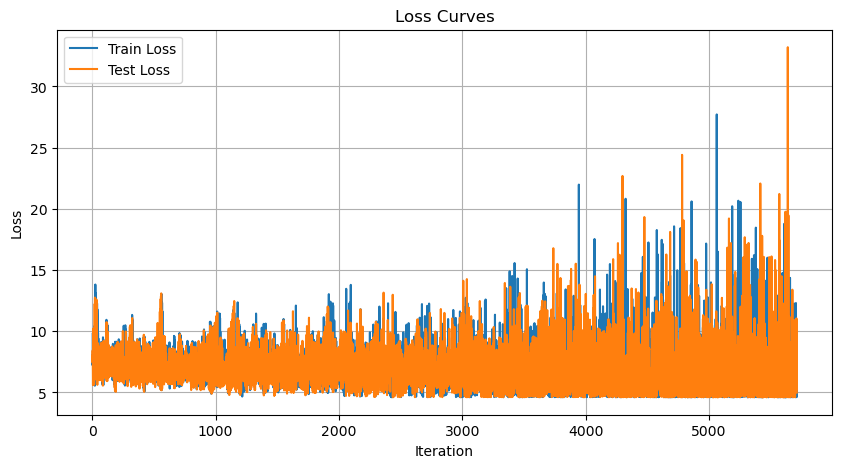

In [33]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Test set accuracy

Instead of computing loss, with is calculated based on membrane potential, use max firing rate to classify:

In [35]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.swapaxes(1,0).flatten(start_dim=2).to(device)
    targets = targets.to(device)

    # forward pass
    preds, vo = net(data)

    # calculate total accuracy
    _, idxs = preds[-1].max(1)  # Take last predictions only, then find max neuron
    total += targets.size(0)
    correct += (idxs == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 4600/10000
Test Set Accuracy: 46.00%
